In [4]:
import math

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.rcParams["mathtext.fontset"] = "cm"

def random_bloom_filter(l: int, k: int, p_flip: float = 0.0) -> np.ndarray:
    bf = np.zeros(l, dtype=int)
    bf[np.random.choice(l, size=k, replace=True)] = 1
    return bf


def flip_bloom_filter(bf: np.ndarray, p_flip: float) -> np.ndarray:
    return np.array([1 - x if np.random.random() < p_flip else x for x in bf])


def dice(a, b) -> float:
    a = np.array(a)
    b = np.array(b)
    return 2 * (a & b).sum() / (a.sum() + b.sum())


def jaccard(a, b) -> float:
    a, b = np.array(a), np.array(b)
    return (a & b).sum() / (a | b).sum()


def similarity(a, b) -> float:
    a, b = np.array(a), np.array(b)
    return (a & b).sum() / len(a)



assert dice([1, 1], [1, 1]) == 1.0
assert dice([0, 0], [1, 1]) == 0.0
assert dice([1, 0], [1, 0]) == 1.0
assert dice([1, 1], [1, 0]) == 0.6666666666666666
assert (
    dice(
        [1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1],
        [1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0],
    )
    == 0.8333333333333334
)

# Helper functions to generate random bloom filters and calculate dice coefficient

def random_flip_dice(l, k, p_flip, score=dice):
    bf = random_bloom_filter(l, k)
    a = flip_bloom_filter(bf, p_flip)
    b = flip_bloom_filter(bf, p_flip)
    return score(a, b)

def random_dice(l, k, score):
    return score(random_bloom_filter(l, k), random_bloom_filter(l, k))


# How similar are two random bloom filters depending on the chosen $k$?

We will take $l=500$ as a reference, and will check the similarity using the Dice coefficient for pairs of randomly generated bloom filters.

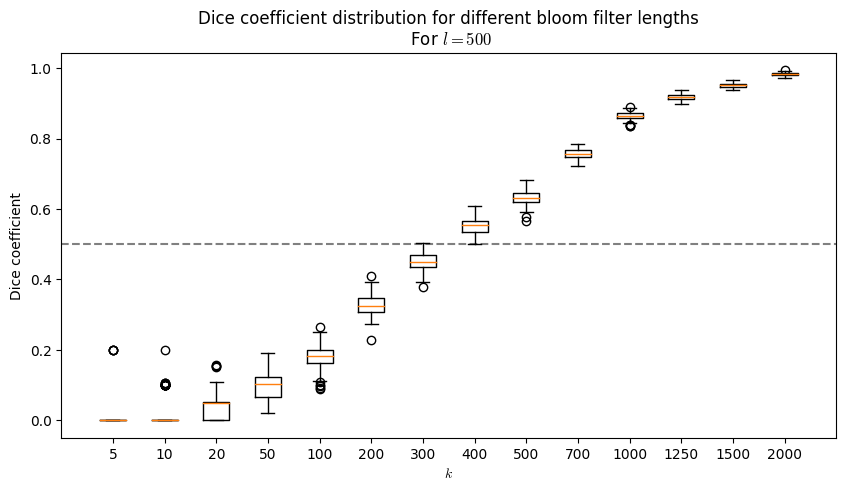

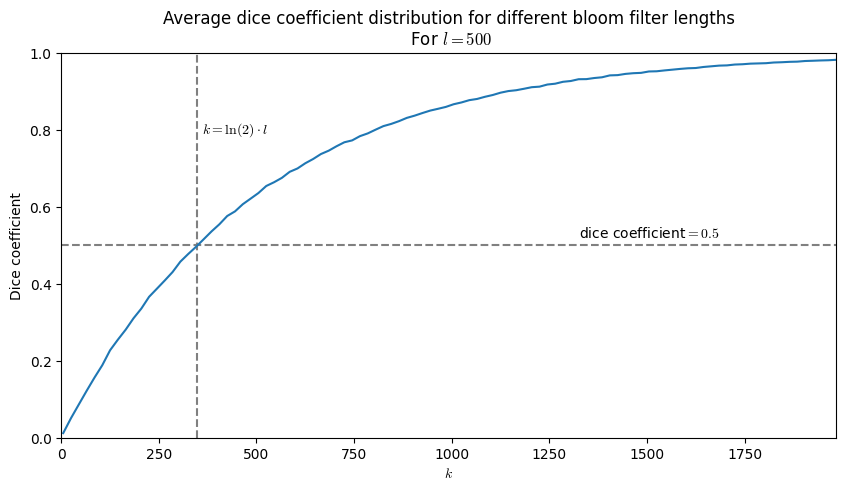

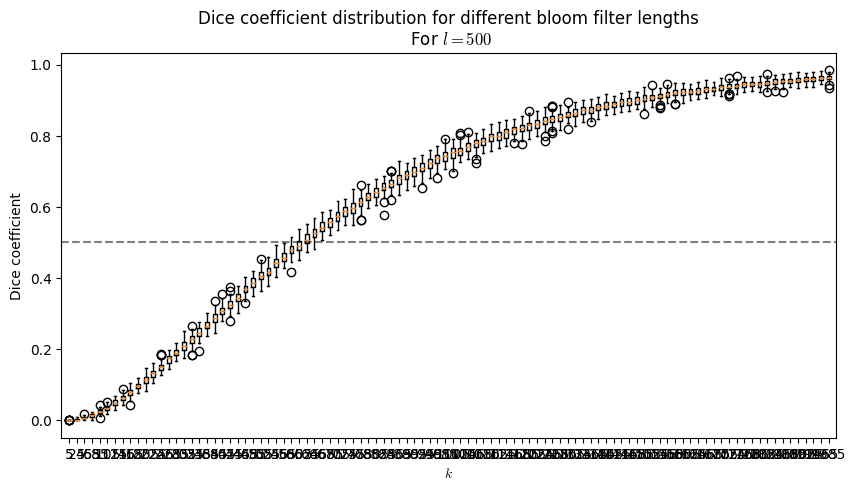

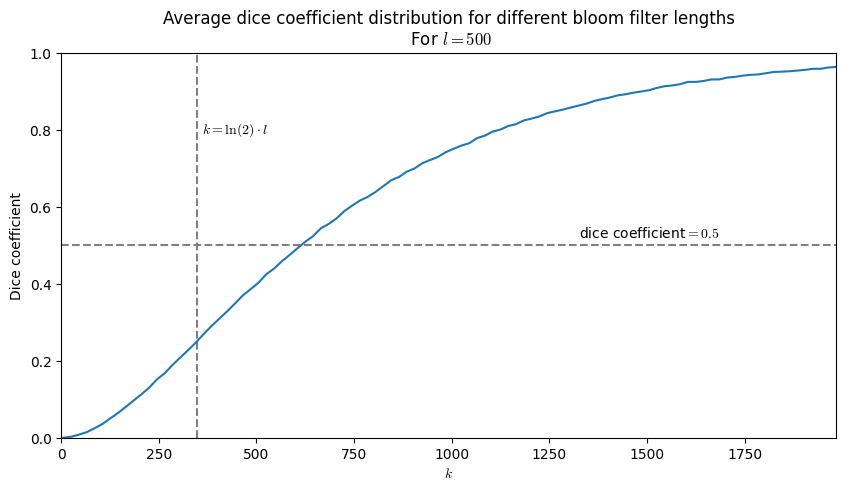

In [5]:
# Parameters
l = 500
N = 100
ks = [5, 10, 20, 50, 100, 200, 300, 400, 500, 700, 1000, 1250, 1500, 2000]

for score in [dice, similarity]:
    # Compute data
    D = [[random_dice(l, k, score) for _ in range(N)] for k in ks]

    # Plot
    plt.figure(figsize=(10,5))
    plt.title(f"Dice coefficient distribution for different bloom filter lengths\n For $l={l}$")
    plt.ylabel("Dice coefficient")
    plt.xlabel("$k$")
    plt.xlim(0, len(ks)+1)
    plt.hlines(0.5, 0, len(ks)+1, colors="gray", linestyles="dashed")
    plt.boxplot(D, labels=ks)

    # Compute data
    ks = list(range(5, 2000, 20))
    D = [[random_dice(l, k, score) for _ in range(N)] for k in ks]

    plt.figure(figsize=(10,5))
    plt.title(f"Average dice coefficient distribution for different bloom filter lengths\n For $l={l}$")
    plt.ylabel("Dice coefficient")
    plt.xlabel("$k$")
    plt.xlim(0, ks[-1])
    plt.ylim(0, 1)
    plt.hlines(0.5, 0, ks[-1], colors="gray", linestyles="dashed")
    plt.text(ks[len(ks)*2//3], 0.52, "dice coefficient$=0.5$")
    plt.vlines(math.log(2)*l, 0, 1, colors="gray", linestyles="dashed")
    plt.text(math.log(2)*l+15, 0.8, "$k = \ln(2) \cdot l$", verticalalignment="center")
    plt.plot(ks, [np.mean(d) for d in D])

#### Conclusions:

* For low $k$, bloom filters are *sparse*, and thus two random bloom filters are pretty dissimilar.
* The average similarity of $0.5$ is reached for $k=\ln{2}\cdot l$, where approximately half bits are 0 and half are 1.
* For larger $k$, bloom filters are *saturated* with ones, and thus are more similar to each other.

# How does the similarity coefficient vary for different bloom filter lengths?

We will take the reference $k$ value of $\ln(2)\cdot l$, and check the similarity distribution for different bloom filter lengths.

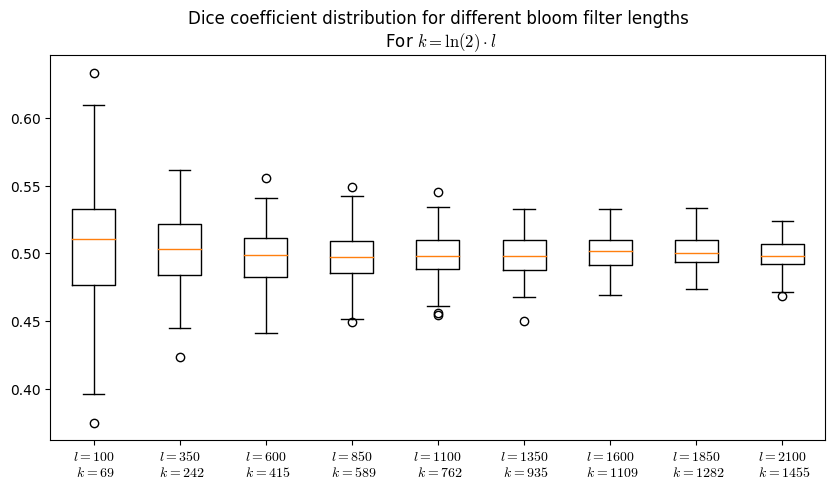

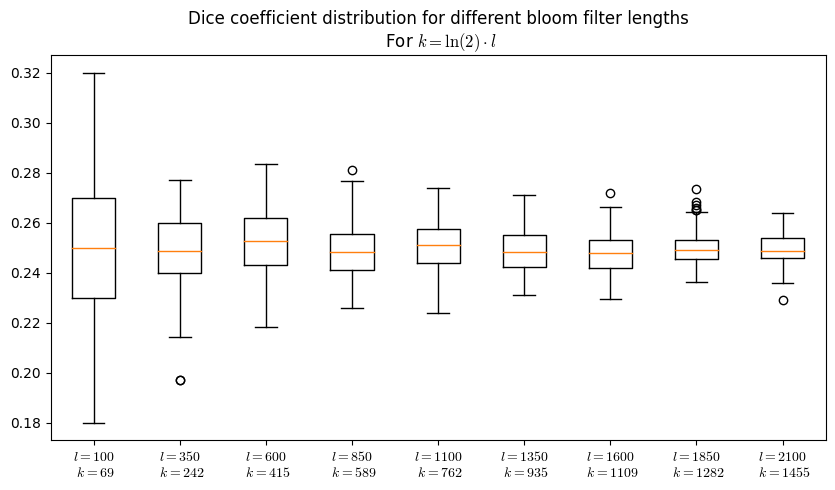

In [7]:
for score in [dice, similarity]:
    # Parameters
    N = 100
    ls = list(range(100, 2101, 250))

    # Compute data
    ks = [int(math.log(2) * l) for l in ls]
    labels = [f"$l={l}$\n $k={k}$" for l, k in zip(ls, ks)]
    D = [[random_dice(l, k, score) for _ in range(N)] for l, k in zip(ls, ks)]

    # Plot
    plt.figure(figsize=(10,5))
    plt.title("Dice coefficient distribution for different bloom filter lengths\n For $k=\ln(2)\cdot l$")
    plt.boxplot(D, labels=labels)

#### Conclusion:

* Longer bloom filters narrow the range of similarities of two random bloom filters.

# What is the similarity of two bloom filters generated by randomly flipping bits of another reference bloom filter?

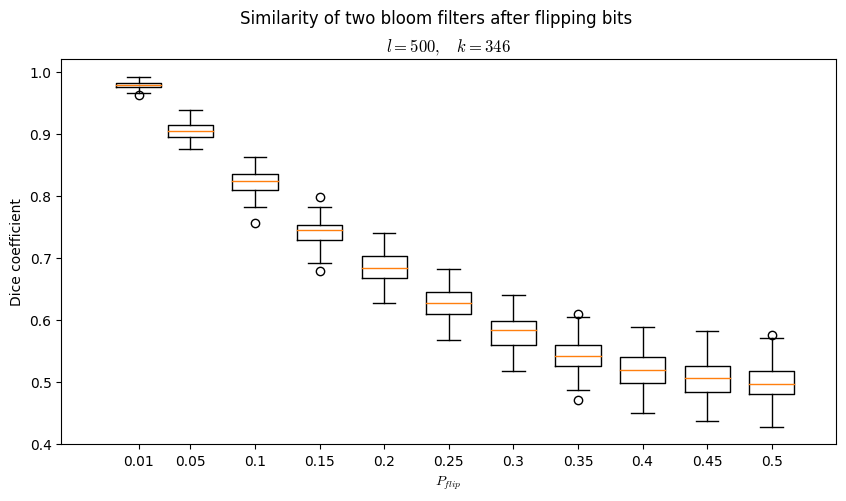

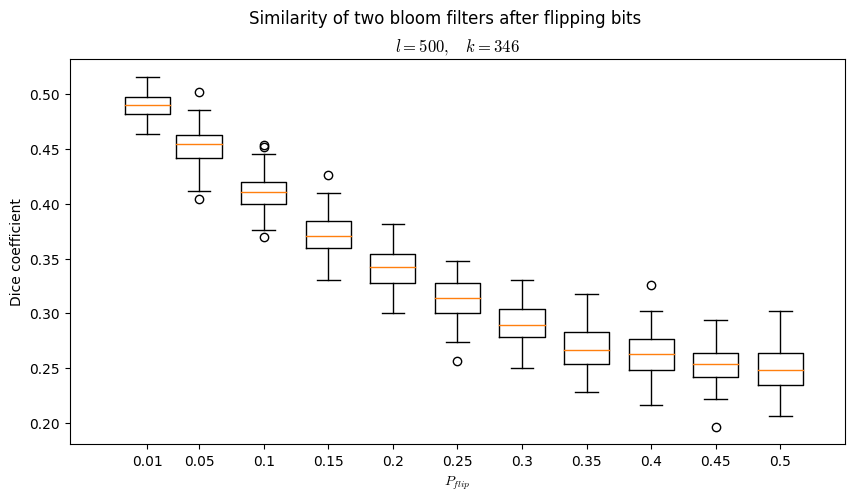

In [8]:
for score in [dice, similarity]:
    # Parameters
    l = 500
    k = 346
    N = 100
    ps_flip = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

    # Compute data
    D = [[random_flip_dice(l, k, p_flip, score) for _ in range(N)] for p_flip in ps_flip]

    # Plot
    plt.figure(figsize=(10,5))
    plt.boxplot(D, positions=ps_flip, widths=0.035)
    plt.xlim(-0.05, 0.55)
    plt.suptitle("Similarity of two bloom filters after flipping bits")
    plt.title(f"$l={l},\quad k={k}$")
    plt.xlabel("$P_{flip}$")
    plt.ylabel("Dice coefficient")

## Conclusion

* Average similarity steadily decreases and is almost completely random for $p_{flip}>0.4$.

# Compare average similarity of two random bloom filters to similarity of two diffused bloom filters

$k$, the number of hash functions, also accounts for:
* The number of elements inserted in the bloom filter (q-grams, ranges, etc.)

Flipping probability can come from:
* Mispellings in the name that cause different q-grams.
* Differential privacy.

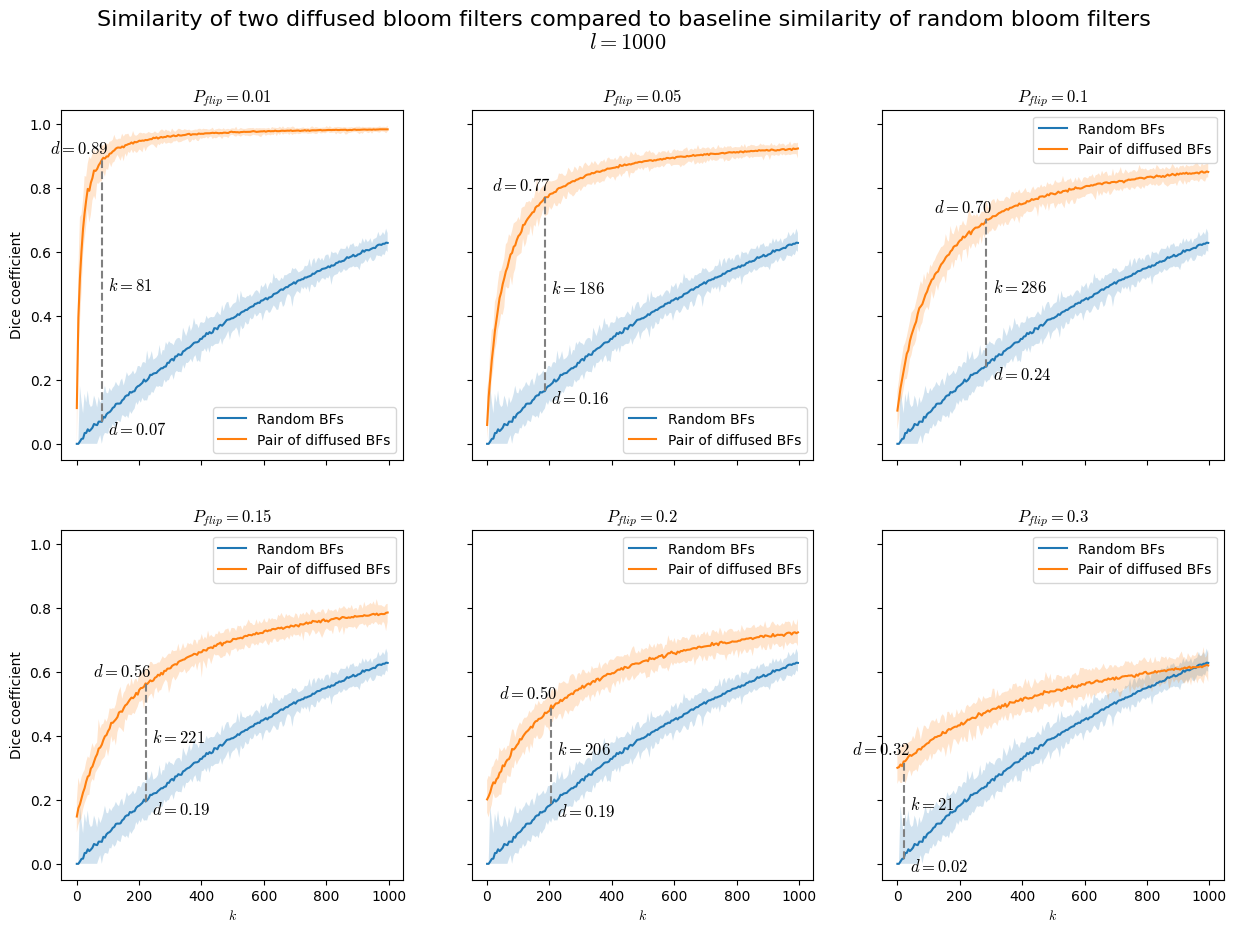

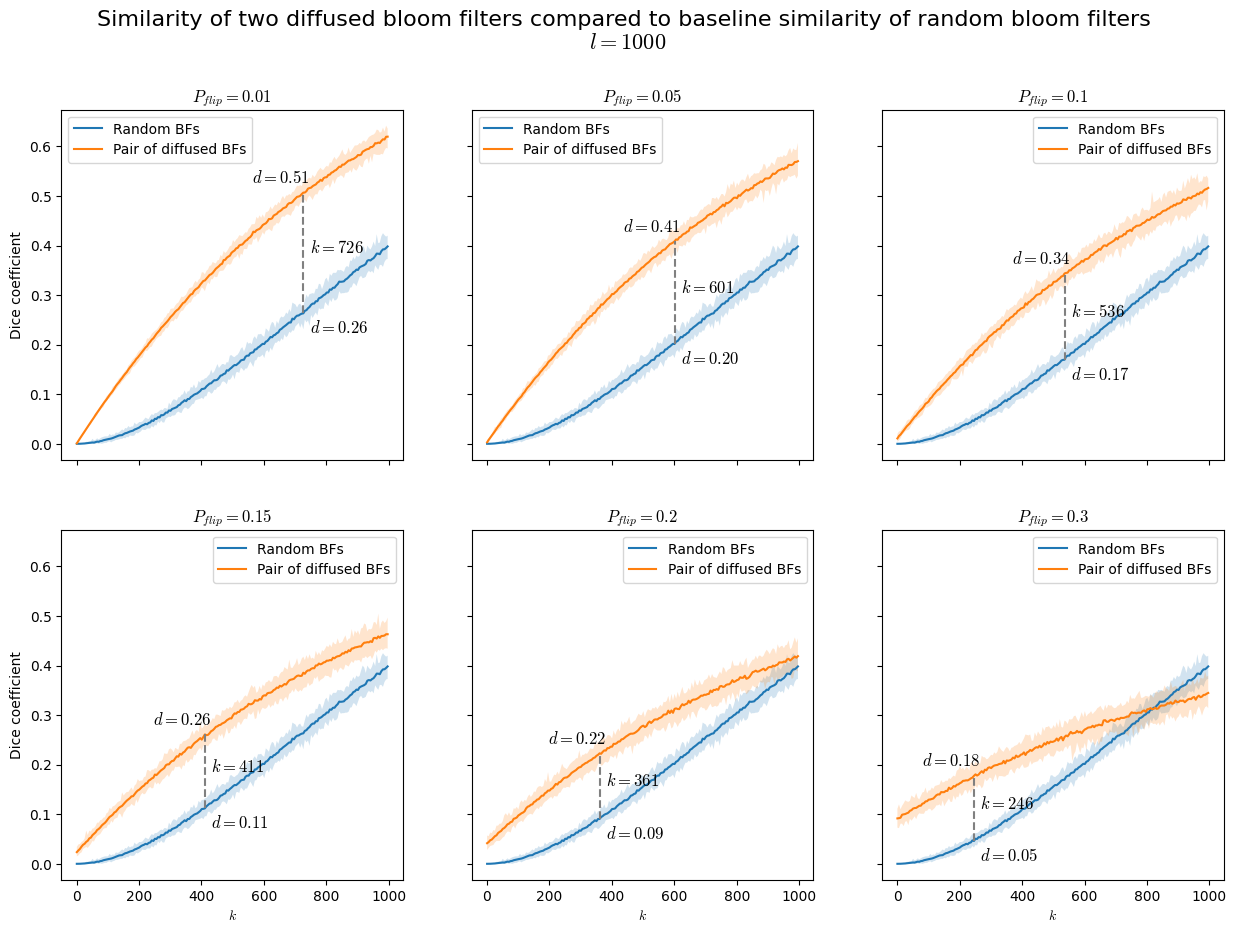

In [9]:
for score in [dice, similarity]:
    # Parameters
    N = 50
    l = 1000
    ks = list(range(1, 1000, 5))
    ps_flip = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3]

    # Generate random bloom filters and compute their distances
    random_bfs_dice = [np.array([random_dice(l, k, score) for _ in range(N)]) for k in ks]

    # Compute the mean, min and max distance for each k
    D_random = [ds.mean() for ds in random_bfs_dice]
    D_random_min = [ds.min() for ds in random_bfs_dice]
    D_random_max = [ds.max() for ds in random_bfs_dice]

    # Configure plot
    fig, axs = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(15, 10))
    fig.suptitle(f"Similarity of two diffused bloom filters compared to baseline similarity of random bloom filters\n $l={l}$", fontsize=16)

    # For each subplot
    for i, p_flip in enumerate(ps_flip):
        # Comptue the distance of two diffused bloom filters
        D_pair, D_pair_low, D_pair_high = [], [], []
        max_difference, best_k, y0, y1 = 0.0, 0, 0, 0
        for d_random, k in zip(D_random, ks):
            d_pair = np.array([random_flip_dice(l, k, p_flip, score) for _ in range(N)])
            D_pair.append(d_pair.mean())
            D_pair_low.append(d_pair.min())
            D_pair_high.append(d_pair.max())

            # Find the k with the largest difference        
            if d_pair.mean() - d_random > max_difference:
                max_difference = d_pair.mean() - d_random
                best_k = k
                y0 = d_random
                y1 = d_pair.mean()

        # Plot
        ax = axs[i//3, i%3]
        ax.plot(ks, D_random, label="Random BFs")
        ax.plot(ks, D_pair, label="Pair of diffused BFs")
        ax.fill_between(ks, D_random_min, D_random_max, alpha=0.2)
        ax.fill_between(ks, D_pair_low, D_pair_high, alpha=0.2)
        ax.legend()
        ax.text(best_k+20, y1+0.02, f"$d={y1:.2f}$", fontsize=12, ha="right")
        ax.text(best_k+20, y0-0.04, f"$d={y0:.2f}$", fontsize=12)
        ax.vlines(x=best_k, ymin=y0, ymax=y1, color="gray", linestyle="dashed")
        ax.text(best_k+20, (y0+y1)/2, f"$k={best_k}$", fontsize=12)
        ax.set_title(f"$P_{{flip}}={p_flip}$")
        if i >= 3:
            ax.set_xlabel("$k$")
        if i % 3 == 0:
            ax.set_ylabel("Dice coefficient")

## Conclusion
* It is very important to choose the right $k$ depending on the flipping probability.
* We can use these plots to decide how many hash functions to use, how much differential privacy, and what kind of expansions to do.

# Differential privacy

In [217]:
# Calculate flip probability for different epsilons

for eps in range(1, 11):
    p_flip = 1.0 / (1.0 + math.exp(eps))
    print(f"eps={eps}, p_flip={p_flip:.5f}")

eps=1, p_flip=0.26894
eps=2, p_flip=0.11920
eps=3, p_flip=0.04743
eps=4, p_flip=0.01799
eps=5, p_flip=0.00669
eps=6, p_flip=0.00247
eps=7, p_flip=0.00091
eps=8, p_flip=0.00034
eps=9, p_flip=0.00012
eps=10, p_flip=0.00005


# Next steps

## Define a protocol to tokenize each field separately

* First name
* Last name
* City
* Date of birth
* ID (passport, social security number)

Things to investigate:
* [Soundex](https://en.wikipedia.org/wiki/Soundex)

## Find a way to evaluate tokenization and linkage together, separately for each field

1. Collect 3 datasets: will all correct data, with some errors and with many errors.
2. Tokenize all records.
3. Plot the similarity of same vs different records.

Question: can we define a threshold? We may need to tweak the tokenization in order to get an optimal one.

4. Define a way to link records: could be via the threshold, could be via clustering or other means.
5. Compute a metric of how good the linkage is.

## Tokenize and link using all different fields.

Compute similarity score for each separate field.

Define a protocol to link full records together.



In [10]:
from hashlib import sha256
from math import exp

import numpy as np


def tokenize(l, k, eps, fields):
    bf = [0] * l
    for field in fields:
        for i in range(k):
            bf[int(sha256(f"{field}#{i}".encode("utf-8")).hexdigest(), 16) % l] = 1
    #return bf
    eta = 1.0 - 1.0 / (1.0 + exp(eps))
    return [bit if np.random.random() <= eta else 1 - bit for bit in bf]


def q_grams(s, q=2, prefix=""):
    s = "".join(filter(str.isalpha, s.lower()))
    if len(s) < 2:
        return [s]
    return [prefix + s[i : i + q] for i in range(len(s) - q + 1)]


def tokenize_name(l, kn, eps, name, prefix):
    expanded = q_grams(name, prefix=prefix)
    k = 1 + kn // len(expanded) # barbara?
    return tokenize(l, k, eps, expanded)


In [12]:
import pandas as pd

# Read three datasets
dfs = [
    pd.read_csv("../data/ncvr_ocp_0.csv", dtype=str),
    pd.read_csv("../data/ncvr_ocp_20.csv", dtype=str),
    pd.read_csv("../data/ncvr_ocp_40.csv", dtype=str),
]

l = 1000
kn = 700
EPS = [1, 2, 3, 4, 5, 10]

# Tokenize first and last names
for eps in EPS:
    tokenize_first_name = lambda name: tokenize_name(l, kn, eps, name, "first_name:")
    tokenize_last_name = lambda name: tokenize_name(l, kn, eps, name, "last_name:")
    
    for df in dfs:
        df[f"first_name_token_{eps}"] = df.first_name.apply(tokenize_first_name)
        df[f"last_name_token_{eps}"] = df.last_name.apply(tokenize_last_name)

In [13]:
# Plot dice scores for each pair
import itertools

comparisons = []
for df in dfs:
    rows = []
    for r1, r2 in itertools.combinations(df.itertuples(), 2):
        row = {
            "id1": r1.id,
            "id2": r2.id,
            "first_name1": r1.first_name,
            "first_name2": r2.first_name,
            "last_name1": r1.last_name,
            "last_name2": r2.last_name,
        }
        for eps in EPS:
            fn_tok = f"first_name_token_{eps}"
            row[f"first_name_{eps}_dice"] = dice(getattr(r1, fn_tok), getattr(r2, fn_tok))
            row[f"first_name_{eps}_similarity"] = similarity(getattr(r1, fn_tok), getattr(r2, fn_tok))
            ln_tok = f"last_name_token_{eps}"
            row[f"last_name_{eps}_dice"] = dice(getattr(r1, ln_tok), getattr(r2, ln_tok))
            row[f"last_name_{eps}_similarity"] = similarity(getattr(r1, ln_tok), getattr(r2, ln_tok))
        rows.append(row)
    comparisons.append(pd.DataFrame.from_records(rows))

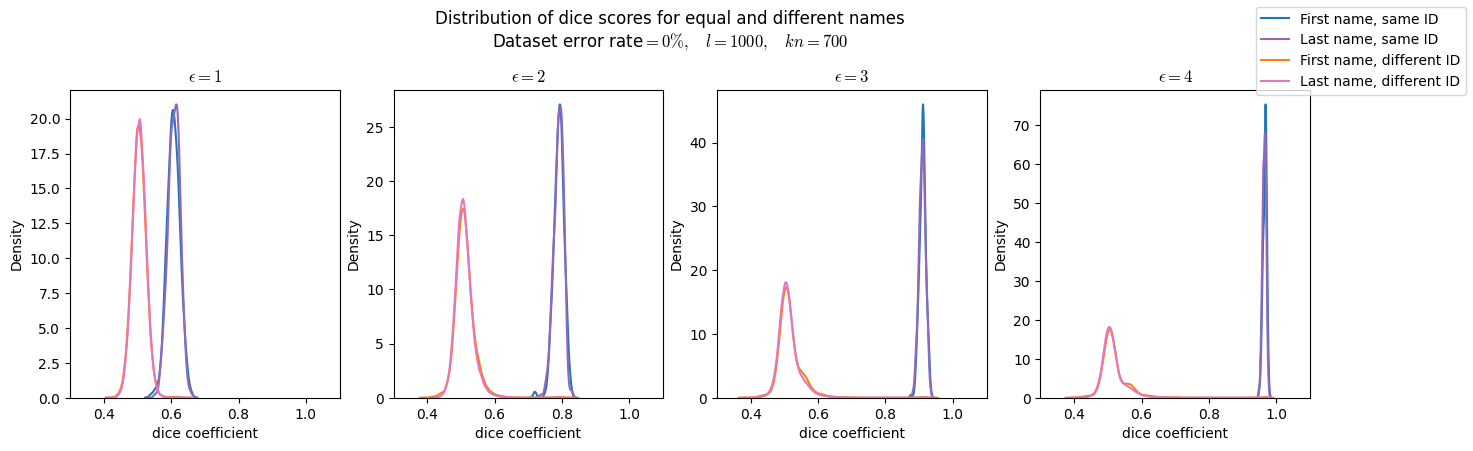

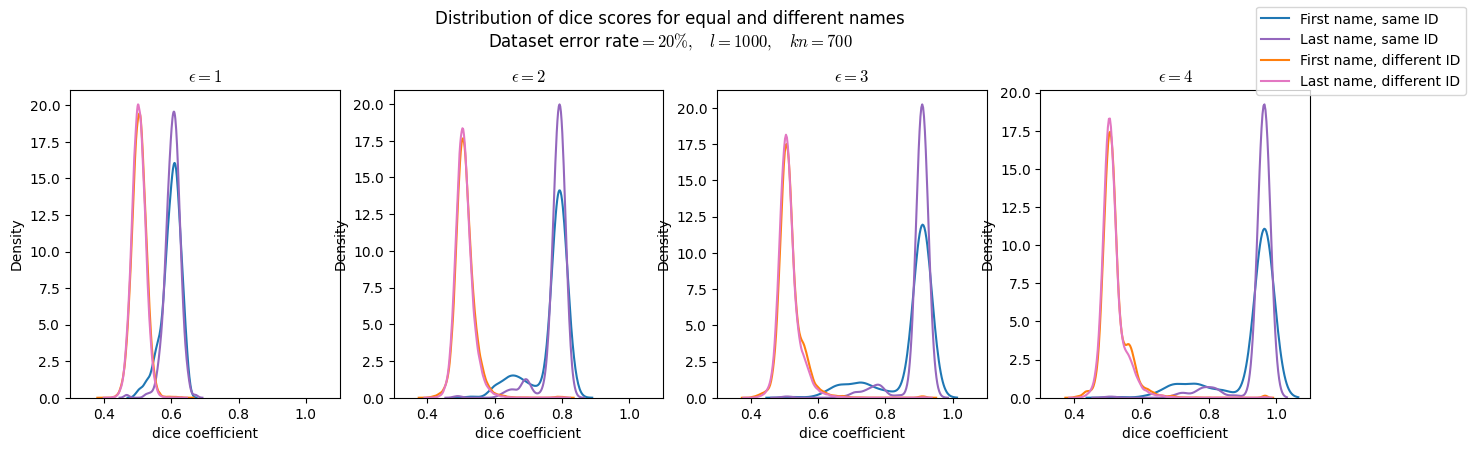

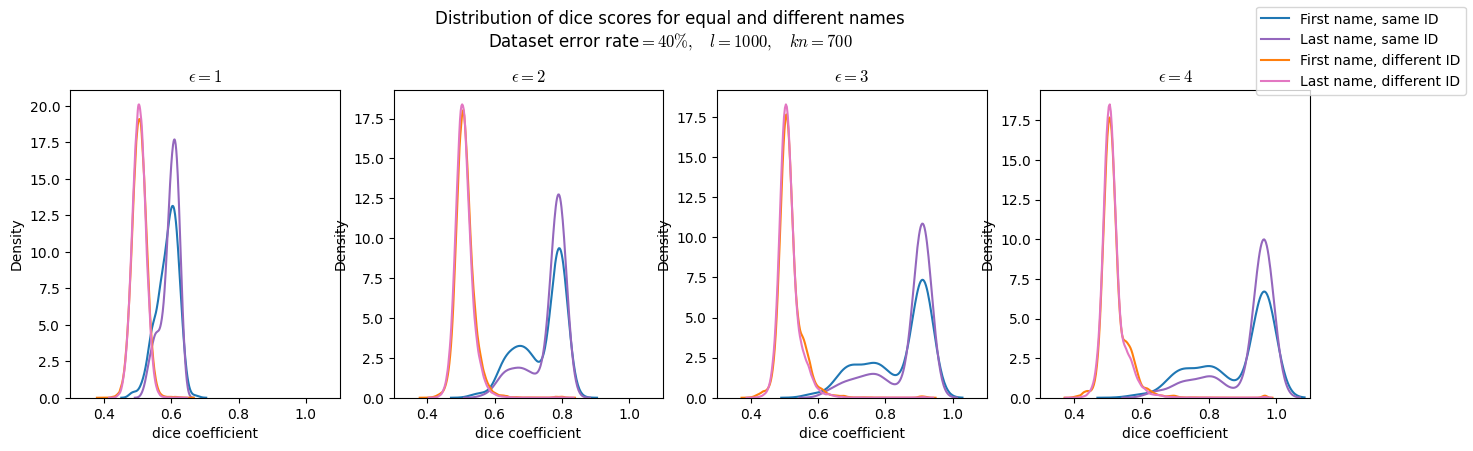

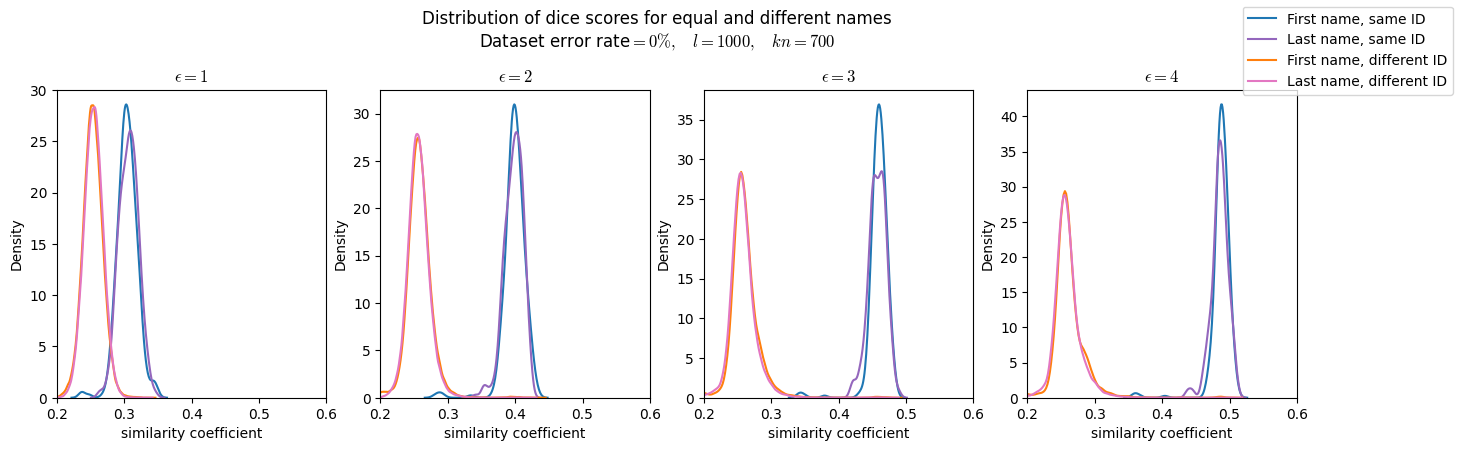

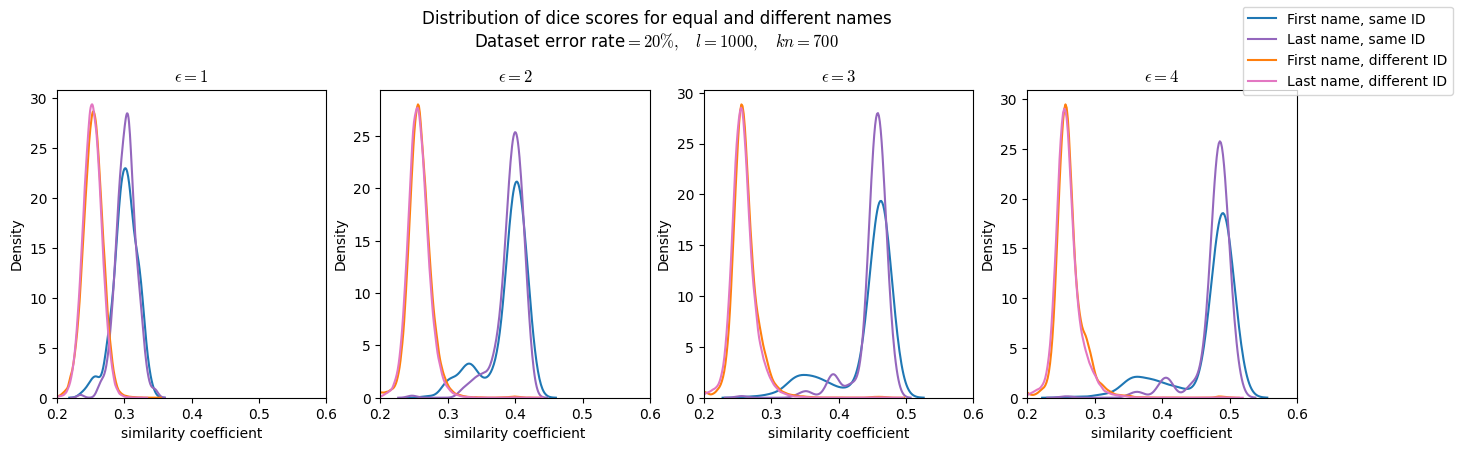

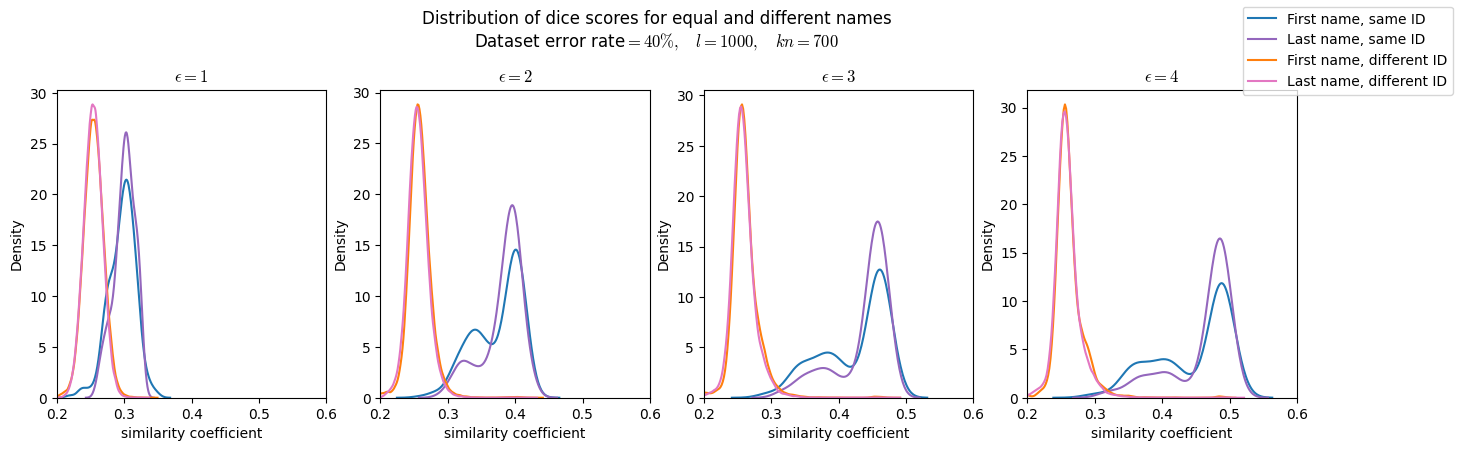

In [17]:
#dices.sort_values("first_name_3_dice", ascending=False, inplace=True)
#print(same_name)
#print(different_name)

for score in ["dice", "similarity"]:
    for error, dices in zip([0, 20, 40], comparisons):
        fig, axs = plt.subplots(1, 4, sharex=True, figsize=(16, 4))

        same_id = dices[dices.id1 == dices.id2]
        different_id = dices[dices.id1 != dices.id2]
        for i, eps in enumerate([1, 2, 3, 4]):
            ax = axs[i]
            sns.kdeplot(same_id[f"first_name_{eps}_{score}"], color="tab:blue", ax=ax)
            sns.kdeplot(same_id[f"last_name_{eps}_{score}"], color="tab:purple", ax=ax)
            sns.kdeplot(different_id[f"first_name_{eps}_{score}"], color="tab:orange", ax=ax)
            sns.kdeplot(different_id[f"last_name_{eps}_{score}"], color="tab:pink", ax=ax)
            ax.set_title(f"$\epsilon={eps}$")
            ax.set_xlabel(f"{score} coefficient")
            if score == "dice":
                ax.set_xlim(0.3, 1.1)
            else:
                ax.set_xlim(0.2, 0.6)
        fig.legend([
            "First name, same ID",
            "Last name, same ID",
            "First name, different ID",
            "Last name, different ID"
        ])
        fig.suptitle(f"Distribution of dice scores for equal and different names\nDataset error rate$= {error}\%,\quad l={l},\quad kn={kn}$", y=1.08)
        plt.show()

/tmp/ipykernel_783091/1166944641.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  same_id[f"sum_{eps}_dice"] = same_id[f"first_name_{eps}_dice"] + same_id[f"last_name_{eps}_dice"]
/tmp/ipykernel_783091/1166944641.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  different_id[f"sum_{eps}_dice"] =  different_id[f"first_name_{eps}_dice"] + different_id[f"last_name_{eps}_dice"]
/tmp/ipykernel_783091/1166944641.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

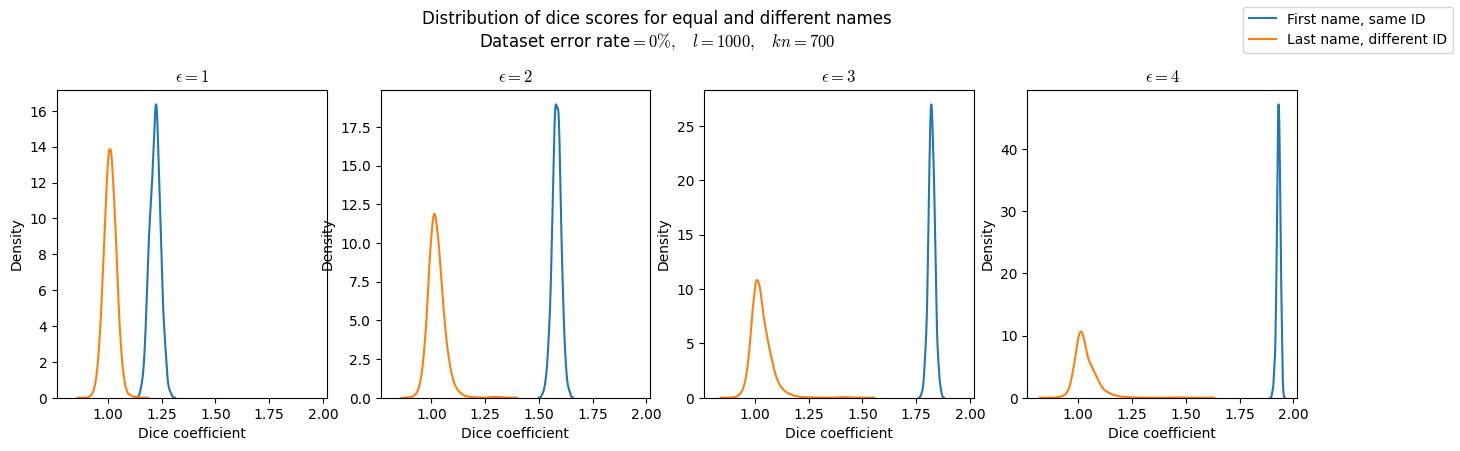

/tmp/ipykernel_783091/1166944641.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  same_id[f"sum_{eps}_dice"] = same_id[f"first_name_{eps}_dice"] + same_id[f"last_name_{eps}_dice"]
/tmp/ipykernel_783091/1166944641.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  different_id[f"sum_{eps}_dice"] =  different_id[f"first_name_{eps}_dice"] + different_id[f"last_name_{eps}_dice"]
/tmp/ipykernel_783091/1166944641.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

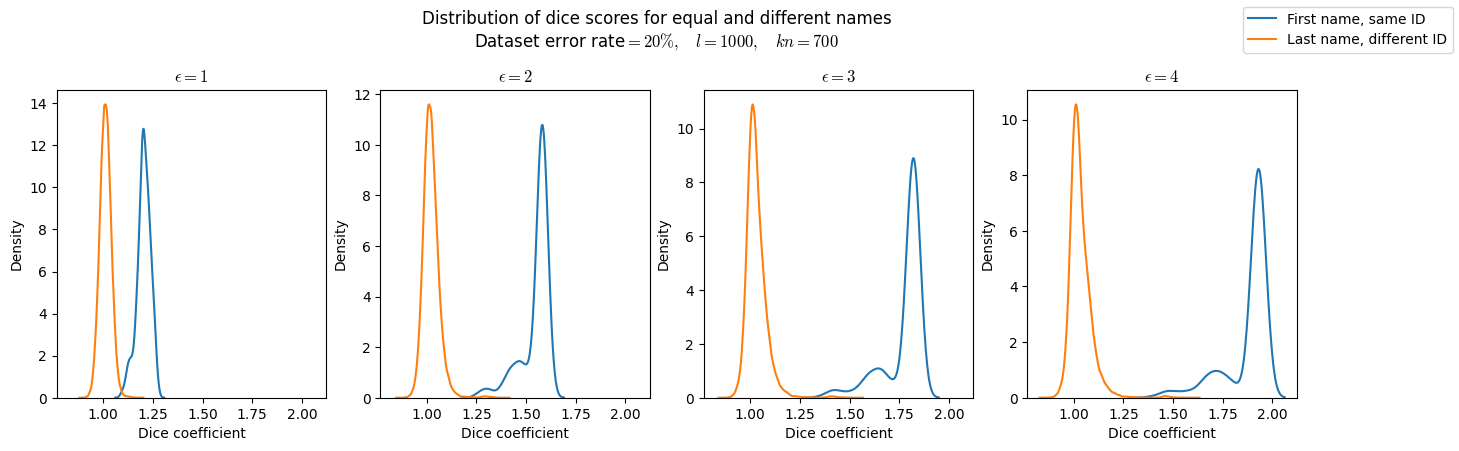

/tmp/ipykernel_783091/1166944641.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  same_id[f"sum_{eps}_dice"] = same_id[f"first_name_{eps}_dice"] + same_id[f"last_name_{eps}_dice"]
/tmp/ipykernel_783091/1166944641.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  different_id[f"sum_{eps}_dice"] =  different_id[f"first_name_{eps}_dice"] + different_id[f"last_name_{eps}_dice"]
/tmp/ipykernel_783091/1166944641.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

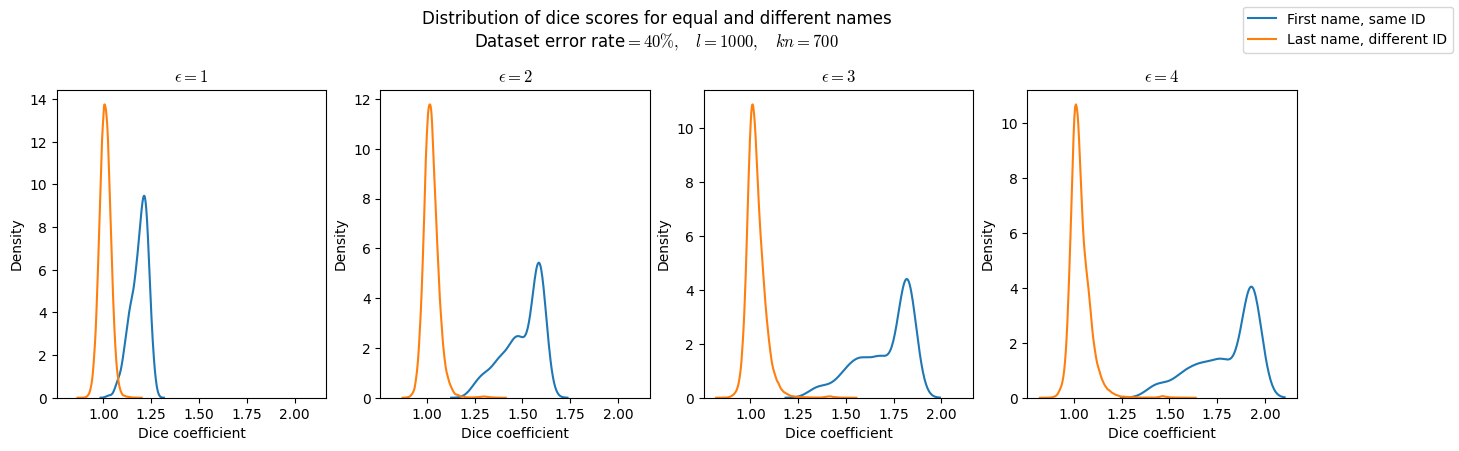

In [22]:
#dices.sort_values("first_name_3_dice", ascending=False, inplace=True)
#print(same_name)
#print(different_name)

for error, dices in zip([0, 20, 40], comparisons):
    fig, axs = plt.subplots(1, 4, sharex=True, figsize=(16, 4))

    same_id = dices[dices.id1 == dices.id2]
    different_id = dices[dices.id1 != dices.id2]
    
    for eps in [1, 2, 3, 4]:
        same_id[f"sum_{eps}_dice"] = same_id[f"first_name_{eps}_dice"] + same_id[f"last_name_{eps}_dice"]
        different_id[f"sum_{eps}_dice"] =  different_id[f"first_name_{eps}_dice"] + different_id[f"last_name_{eps}_dice"]
    
    for i, eps in enumerate([1, 2, 3, 4]):
        same_sums = same_id[f"first_name_{eps}_dice"] + same_id[f"last_name_{eps}_dice"]
        diff_sums =  different_id[f"first_name_{eps}_dice"] + different_id[f"last_name_{eps}_dice"]
        ax = axs[i]
        sns.kdeplot(same_sums, color="tab:blue", ax=ax)
        sns.kdeplot(diff_sums, color="tab:orange", ax=ax)
        ax.set_title(f"$\epsilon={eps}$")
        ax.set_xlabel("Dice coefficient")
        #ax.set_xlim(0.3, 2.1)
    fig.legend([
        "First name, same ID",
        "Last name, different ID"
    ])
    fig.suptitle(f"Distribution of dice scores for equal and different names\nDataset error rate$= {error}\%,\quad l={l},\quad kn={kn}$", y=1.08)
    plt.show()

In [32]:
cutoff = 1.5

different_id.sort_values("sum_3_dice", ascending=False)

,id1,id2,first_name1,first_name2,last_name1,last_name2,first_name_1_dice,last_name_1_dice,first_name_2_dice,last_name_2_dice,...,first_name_4_dice,last_name_4_dice,first_name_5_dice,last_name_5_dice,first_name_10_dice,last_name_10_dice,sum_1_dice,sum_2_dice,sum_3_dice,sum_4_dice
15952,07476219,01597586,kimberly,kimberly,thomas,thorpe,0.636187,0.556107,0.778109,0.596985,...,0.962963,0.658777,0.990955,0.660079,1.000000,0.667992,1.192294,1.375094,1.539969,1.621740
71180,01603366,05843117,mark,carol,farmer,farmer,0.500982,0.597815,0.575937,0.806807,...,0.600995,0.966337,0.605159,0.984252,0.604790,1.000000,1.098798,1.382744,1.533065,1.567332
53617,05925767,05365451,william,william,macon,coleman,0.609562,0.528942,0.778218,0.572597,...,0.965585,0.615538,0.987192,0.620896,1.000000,0.621379,1.138504,1.350815,1.520488,1.581123
95822,00588121,04381862,eric,eric,boone,throneburg,0.604230,0.513761,0.794118,0.541625,...,0.969880,0.590684,0.986987,0.597610,1.000000,0.597610,1.117991,1.335743,1.517370,1.560563
72046,00557786,00421552,judith,claudia,davis,davis,0.517382,0.603622,0.550403,0.786139,...,0.620140,0.968969,0.610945,0.992951,0.619381,1.000000,1.121004,1.336542,1.515159,1.589109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73517,00609394,05636907,barbara,daniel,taylor,gilreat,0.450000,0.458418,0.431072,0.486647,...,0.405467,0.492582,0.405467,0.487709,0.400458,0.486166,0.908418,0.917719,0.858308,0.898049
73644,00609394,07384830,barbara,daniel,taylor,hughes,0.472076,0.469636,0.434024,0.499010,...,0.414579,0.489152,0.405467,0.472441,0.400458,0.476285,0.941711,0.933034,0.856829,0.903730
101037,00609394,01742869,barbara,patricia,taylor,church,0.457754,0.512871,0.457143,0.452431,...,0.408889,0.429646,0.411568,0.434225,0.408482,0.431330,0.970625,0.909574,0.856343,0.838534
117550,00609394,01742869,barbara,patricia,taylor,church,0.487958,0.486056,0.465409,0.451477,...,0.410256,0.432900,0.413333,0.427497,0.408482,0.431330,0.974014,0.916886,0.847914,0.843157


In [31]:
same_id.sort_values("sum_3_dice", ascending=True)[same_id.sum_3_dice < cutoff]

/tmp/ipykernel_783091/3848634101.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  same_id.sort_values("sum_3_dice", ascending=True)[same_id.sum_3_dice < cutoff]


,id1,id2,first_name1,first_name2,last_name1,last_name2,first_name_1_dice,last_name_1_dice,first_name_2_dice,last_name_2_dice,...,first_name_4_dice,last_name_4_dice,first_name_5_dice,last_name_5_dice,first_name_10_dice,last_name_10_dice,sum_1_dice,sum_2_dice,sum_3_dice,sum_4_dice
44352,02158195,02158195,ernest,ernst,cave,caev,0.558000,0.519270,0.637427,0.593598,...,0.742690,0.662791,0.757605,0.657507,0.766082,0.654902,1.077270,1.231025,1.321690,1.405481
79402,02158195,02158195,ernest,ernst,cave,caev,0.562313,0.505653,0.668651,0.616585,...,0.751456,0.656920,0.759766,0.653582,0.766082,0.654902,1.067966,1.285236,1.323763,1.408376
104452,02158195,02158195,ernest,ernst,cave,caev,0.567404,0.544330,0.652941,0.573399,...,0.751468,0.660194,0.758285,0.654902,0.766082,0.654902,1.111734,1.226340,1.324643,1.411662
105442,02158195,02158195,ernst,ernest,caev,cave,0.575258,0.508065,0.679463,0.602927,...,0.749268,0.655674,0.759766,0.649020,0.766082,0.654902,1.083322,1.282389,1.330731,1.404942
48604,03871619,03871619,tifgany,diffany,lowery,loweyr,0.495885,0.532242,0.622000,0.632000,...,0.673327,0.743487,0.677291,0.747253,0.683948,0.758000,1.028126,1.254000,1.344037,1.416814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45735,01761680,01761680,glencla,glenda,waddell,waddell,0.544191,0.572885,0.627136,0.816286,...,0.709613,0.970179,0.714428,0.985104,0.720398,1.000000,1.117075,1.443422,1.585712,1.679792
1198,00406646,00406646,milded,mildred,morrison,morison,0.576238,0.596457,0.618328,0.747082,...,0.748527,0.893954,0.783546,0.907843,0.783546,0.918387,1.172694,1.365410,1.588648,1.642481
82535,01341351,01341351,bedty,betty,horne,horne,0.568160,0.596527,0.626576,0.771229,...,0.687739,0.964322,0.686160,0.984741,0.695652,1.000000,1.164687,1.397805,1.591799,1.652062
80675,00567333,00567333,lina,linda,doss,doss,0.571984,0.603205,0.603659,0.785215,...,0.709677,0.968932,0.711246,0.984436,0.716751,0.999028,1.175189,1.388873,1.594732,1.678609
